In [1]:
import numpy as np
import pandas as pd
from inference import inf_model, policy
from evaluate.evaluation import Evaluatemethod 
from miss_fill.context_fill import cluster_fill, KNN_fill, DR_fill
from miss_fill.mean_fill import mean_fill, tr_mean_fill

# for visualization
import matplotlib.pyplot as plt
import seaborn as sns


## Scenario: 
Data with out context with block length 1

### Data

In [2]:
df1 = pd.read_csv('data/two_treatment/dt1_2024_11_10_without_context.csv' ,index_col=0)
df1.head(10)

,t,patient_id,treatment,outcome
0,0,0,1,0.125730
1,1,0,0,1.867895
2,2,0,0,2.640423
3,3,0,0,2.104900
4,4,0,0,1.464331
5,5,0,0,2.361595
6,0,1,0,2.345584
7,1,1,0,2.821618
8,2,1,0,2.330437
9,3,1,0,0.696843


#### creating random nan values

In [4]:
df = df1.copy()
column = 'outcome'
# Parameters
thr_t = 0    # Condition: missing at time cycle 0
num_nans = 10    # 10% of the data in column B will be set to NaN

# Find indices where column 'B' is greater than the threshold
eligible_indices = df.index[df['t'] == thr_t]

# seed for reproducibility
np.random.seed(0)
# Select random indices from the eligible ones
random_indices = np.random.choice(eligible_indices, size=num_nans, replace=False)

# Set NaN at those random indices
df.loc[random_indices, column] = np.nan

In [5]:
# the patient who have the missing outcomes
missing_patient_id = df.loc[df['outcome'].isna(), 'patient_id'].values

In [6]:
## seperating the dataframe at the point of first missing value
dt = df[df['t']<= thr_t].copy()
dt.head()

,t,patient_id,treatment,outcome
0,0,0,1,0.125730
6,0,1,0,2.345584
12,0,2,1,NaN
18,0,3,0,4.040919
24,0,4,1,-0.651791


### making simulation for the next action choice 

In [7]:
# Policy and Inference Model
inference_model =  inf_model.NormalKnownVariance(
    
    prior_mean=0, prior_variance=1, variance=1
)
tmps = policy.ThompsonSampling(inference_model, number_of_treatments=2)

In [8]:
# Initial parameters
block_length = 1
length = 6 * block_length
number_of_actions = 2
number_of_patients = 100
pop_mean = [0,0]
pop_variance = [1,1]

In [9]:
missing_patient_id

array([ 2, 16, 26, 54, 55, 73, 75, 86, 93, 95], dtype=int64)

In [10]:
## intialization for running all the methods
t = 1 # for evaluation method
k = 3
N = 2
m = 1
lamb = 2
context_cols = ['treatment', 'patient_id']


In [11]:
## create a dictionary for all the methods

methods = {
    'mean_fill': mean_fill,
    'tr_mean_fill': tr_mean_fill,
    'KNN_fill': KNN_fill,
    'cluster_fill': cluster_fill,
    'DR_fill': DR_fill,
    'original': 0,
}

In [ ]:
result = pd.DataFrame()
eva = Evaluatemethod(t, df1)
for method_name, method in methods.items():
    if method == KNN_fill:
        filled_dt =method(dt, context_cols, k) 
        ## GET THE EVALUATION
        n_correct_tr, index = eva.get_result(filled_dt)
        result[f'{method_name}'] = n_correct_tr    
    elif method == cluster_fill:
        filled_dt =method(dt, context_cols, N, m)
        ## GET THE EVALUATION
        n_correct_tr, index = eva.get_result(filled_dt)
        result[f'{method_name}'] = n_correct_tr
    elif method == DR_fill:
        filled_dt =method(dt,lamb, context_cols)
        ## GET THE EVALUATION
        n_correct_tr, index = eva.get_result(filled_dt)
        result[f'{method_name}'] = n_correct_tr
        
    elif method == DR_fill:
        filled_dt =method(dt,lamb, context_cols)
        ## GET THE EVALUATION
        n_correct_tr, index = eva.get_result(filled_dt)
        result[f'{method_name}'] = n_correct_tr
    elif method == mean_fill:
        filled_dt_g =method(dt)
        ## GET THE EVALUATION
        n_correct_tr_g, index = eva.get_result(filled_dt= filled_dt_g)
        result[f'{method_name} (global)'] = n_correct_tr_g
        
        # for individual
        filled_dt =method(dt, method = 'individual')
        ## GET THE EVALUATION
        n_correct_tr, index = eva.get_result(filled_dt)
        result[f'{method_name} (individual)'] = n_correct_tr
        
    elif method == tr_mean_fill:
        filled_dt_g =method(dt)
        ## GET THE EVALUATION
        n_correct_tr_g, index = eva.get_result(filled_dt_g)
        result[f'{method_name} (global)'] = n_correct_tr_g
        
        # for individual
        filled_dt =method(dt, method = 'individual')
        ## GET THE EVALUATION
        n_correct_tr, index = eva.get_result(filled_dt)
        result[f'{method_name} (individual)'] = n_correct_tr
    else:
        filled_dt =df1[df1['t'] == 0] ## for the original data
        ## GET THE EVALUATION
        n_correct_tr, index = eva.get_result(filled_dt)
        result['original_data'] = n_correct_tr
        

    print(f'done for {method_name}')
result['patient_id'] = index

result = result.set_index('patient_id')

done for mean_fill
done for tr_mean_fill
done for KNN_fill


c:\ProgramData\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


done for cluster_fill
done for DR_fill


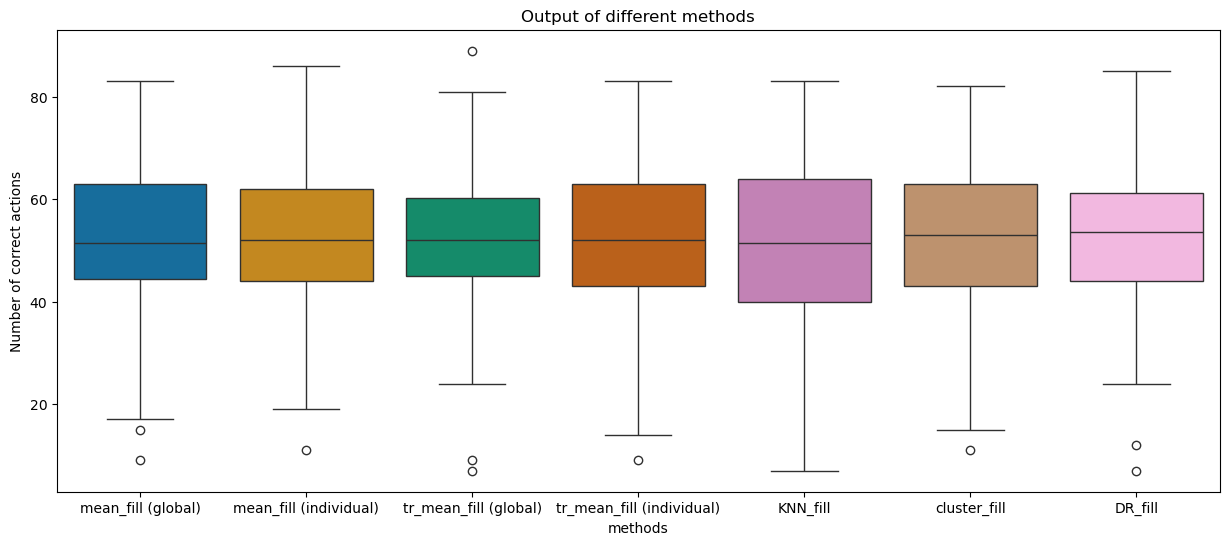

In [17]:
df_melted = result.melt(var_name='Columns', value_name='Values')

# Create a box plot with Seaborn
plt.figure(figsize=(15, 6))
sns.boxplot(x='Columns', y='Values', data=df_melted, hue='Columns', palette='colorblind')

# Add title and labels
plt.title('Output of different methods')
plt.xlabel('methods')
plt.ylabel('Number of correct actions')

# Show the plot
plt.show()

In [ ]:
result.to_csv('result_output/result_block1wot1_action_selection.csv', index = True)

#### Getting the posterior mean

In [77]:
import scipy.stats as stats

def confidence_interval(df, column, confidence_level=0.95):
        
    sample = df[column]
    n = len(sample)                       # Sample size
    mean = sample.mean()                  # Mean of the sample
    std_err = sample.sem()                # Standard error of the mean

    # Calculate the margin of error
    margin_of_error = stats.t.ppf((1 + confidence_level) / 2, n - 1) * std_err

    # Calculate confidence interval
    lower_bound = mean - margin_of_error
    upper_bound = mean + margin_of_error

    return (lower_bound, upper_bound)

def get_mean_var(filled_dt, n_sim):
    
    mean_0 = []
    mean_1 = []
    var_0 = []
    var_1 = []
    for i in range(0, n_sim):
        new_dt = get_newdt(filled_dt, missing_patient_id)
        mean, var = inference_model.update_posterior(new_dt, number_of_actions)
        mean_0.append(mean[0])
        mean_1.append(mean[1])
        var_0.append(var[0])
        var_1.append(var[1])
    output = {
        'mean of treatment 0': mean_0,
        'mean of treatment 1': mean_1,
        'variance of treatment 0': var_0,
        'variance of treatment 1': var_1, 
    }
    return pd.DataFrame(output)
    

In [12]:
eva = Evaluatemethod(t,length, df1)

In [13]:

## gettig the posterior mean and variance of the simulayed data
mean_0 = []
mean_1 = []
lower_bound_tr0 = []
upper_bound_tr0 = []
lower_bound_tr1 = []
upper_bound_tr1 = []
original_data_mean_0 = []
original_data_mean_1 = []

for method_name, method in methods.items():
    if method == KNN_fill:
        filled_dt =method(dt, context_cols, k)
        ## GET THE EVALUATION
        KNN_out = eva.get_mean_var(filled_dt, missing_patient_id)
        lower_bound0, upper_bound0 = eva.confidence_interval(KNN_out, 'mean of treatment 0')
        lower_bound1, upper_bound1 = eva.confidence_interval(KNN_out, 'mean of treatment 1')
        mean_a, var_a = inference_model.update_posterior(df1, number_of_actions)
        
        ## append all data
        mean_0.append(KNN_out['mean of treatment 0'].mean())
        mean_1.append(KNN_out['mean of treatment 1'].mean())
        lower_bound_tr0.append(lower_bound0)
        upper_bound_tr0.append(upper_bound0)
        lower_bound_tr1.append(lower_bound1)
        upper_bound_tr1.append(upper_bound1)
        original_data_mean_0.append(mean_a[0])
        original_data_mean_1.append(mean_a[1])
                   
        
    elif method == cluster_fill:
        filled_dt =method(dt, context_cols, N, m)
        ## GET THE EVALUATION
        cluster_out = eva.get_mean_var(filled_dt, missing_patient_id)
        lower_bound0, upper_bound0 = eva.confidence_interval(cluster_out, 'mean of treatment 0')
        lower_bound1, upper_bound1 = eva.confidence_interval(cluster_out, 'mean of treatment 1')
        mean_a, var_a = inference_model.update_posterior(df1, number_of_actions)
        
        ## append all data
        mean_0.append(cluster_out['mean of treatment 0'].mean())
        mean_1.append(cluster_out['mean of treatment 1'].mean())
        lower_bound_tr0.append(lower_bound0)
        upper_bound_tr0.append(upper_bound0)
        lower_bound_tr1.append(lower_bound1)
        upper_bound_tr1.append(upper_bound1)
        original_data_mean_0.append(mean_a[0])
        original_data_mean_1.append(mean_a[1])
        
        
    elif method == DR_fill:
        filled_dt =method(dt,lamb, context_cols)
               ## GET THE EVALUATION
        DR_out = eva.get_mean_var(filled_dt, missing_patient_id)
        lower_bound0, upper_bound0 = eva.confidence_interval(DR_out, 'mean of treatment 0')
        lower_bound1, upper_bound1 = eva.confidence_interval(DR_out, 'mean of treatment 1')
        mean_a, var_a = inference_model.update_posterior(df1, number_of_actions)
        
        ## append all data
        mean_0.append(DR_out['mean of treatment 0'].mean())
        mean_1.append(DR_out['mean of treatment 1'].mean())
        lower_bound_tr0.append(lower_bound0)
        upper_bound_tr0.append(upper_bound0)
        lower_bound_tr1.append(lower_bound1)
        upper_bound_tr1.append(upper_bound1)
        original_data_mean_0.append(mean_a[0])
        original_data_mean_1.append(mean_a[1])
        

    elif method == mean_fill:
        filled_dt_g =method(dt)
        ## GET THE EVALUATION
        meanG_out = eva.get_mean_var(filled_dt_g, missing_patient_id)
        lower_bound0, upper_bound0 = eva.confidence_interval(meanG_out, 'mean of treatment 0')
        lower_bound1, upper_bound1 = eva.confidence_interval(meanG_out, 'mean of treatment 1')
        mean_a, var_a = inference_model.update_posterior(df1, number_of_actions)
        
        ## append all data
        mean_0.append(meanG_out['mean of treatment 0'].mean())
        mean_1.append(meanG_out['mean of treatment 1'].mean())
        lower_bound_tr0.append(lower_bound0)
        upper_bound_tr0.append(upper_bound0)
        lower_bound_tr1.append(lower_bound1)
        upper_bound_tr1.append(upper_bound1)
        original_data_mean_0.append(mean_a[0])
        original_data_mean_1.append(mean_a[1])
        
        # for individual
        filled_dt =method(dt, method = 'individual')
               ## GET THE EVALUATION
        meanI_out = eva.get_mean_var(filled_dt, missing_patient_id)
        lower_bound0, upper_bound0 = eva.confidence_interval(meanI_out, 'mean of treatment 0')
        lower_bound1, upper_bound1 = eva.confidence_interval(meanI_out, 'mean of treatment 1')
        mean_a, var_a = inference_model.update_posterior(df1, number_of_actions)
        
        ## append all data
        mean_0.append(meanI_out['mean of treatment 0'].mean())
        mean_1.append(meanI_out['mean of treatment 1'].mean())
        lower_bound_tr0.append(lower_bound0)
        upper_bound_tr0.append(upper_bound0)
        lower_bound_tr1.append(lower_bound1)
        upper_bound_tr1.append(upper_bound1)
        original_data_mean_0.append(mean_a[0])
        original_data_mean_1.append(mean_a[1])
        
    elif method == tr_mean_fill:
        filled_dt_g =method(dt)
        ## GET THE EVALUATION
        tr_meanG_out = eva.get_mean_var(filled_dt_g, missing_patient_id)
        lower_bound0, upper_bound0 = eva.confidence_interval(tr_meanG_out, 'mean of treatment 0')
        lower_bound1, upper_bound1 = eva.confidence_interval(tr_meanG_out, 'mean of treatment 1')
        mean_a, var_a = inference_model.update_posterior(df1, number_of_actions)
        
        ## append all data
        mean_0.append(tr_meanG_out['mean of treatment 0'].mean())
        mean_1.append(tr_meanG_out['mean of treatment 1'].mean())
        lower_bound_tr0.append(lower_bound0)
        upper_bound_tr0.append(upper_bound0)
        lower_bound_tr1.append(lower_bound1)
        upper_bound_tr1.append(upper_bound1)
        original_data_mean_0.append(mean_a[0])
        original_data_mean_1.append(mean_a[1])
        
        # for individual
        filled_dt =method(dt, method = 'individual')
        ## GET THE EVALUATION
        tr_meanI_out = eva.get_mean_var(filled_dt, missing_patient_id)
        lower_bound0, upper_bound0 = eva.confidence_interval(tr_meanI_out, 'mean of treatment 0')
        lower_bound1, upper_bound1 = eva.confidence_interval(tr_meanI_out, 'mean of treatment 1')
        mean_a, var_a = inference_model.update_posterior(df1, number_of_actions)
        
        ## append all data
        mean_0.append(tr_meanI_out['mean of treatment 0'].mean())
        mean_1.append(tr_meanI_out['mean of treatment 1'].mean())
        lower_bound_tr0.append(lower_bound0)
        upper_bound_tr0.append(upper_bound0)
        lower_bound_tr1.append(lower_bound1)
        upper_bound_tr1.append(upper_bound1)
        original_data_mean_0.append(mean_a[0])
        original_data_mean_1.append(mean_a[1])


TypeError: 'tuple' object cannot be interpreted as an integer

In [16]:
par_estimation_result= {
    'method': ["mean_fill (global)", "mean_fill (individual)", "tr_mean_fill (global)", "tr_mean_fill (individual)", "KNN_fill", "cluster_fill",
               "DR_fill"],
    'posterior mean of treatment 0': mean_0,
    'treatment 0 lower bound (95%)': lower_bound0,
    'treatment 0 upper bound (95%)': upper_bound0,
    'posterior mean of treatment 0 (original data )': original_data_mean_0,
    'posterior mean of treatment 1': mean_1,
    'treatment 1 lower bound (95%)': lower_bound1,
    'treatment 1 upper bound (95%)': upper_bound1,
    'posterior mean of treatment 1 (original data )': original_data_mean_1
}

In [19]:
mean_0

[1.968739285885601]

In [18]:
par_estimation_result

{'method': ['mean_fill (global)',
  'mean_fill (individual)',
  'tr_mean_fill (global)',
  'tr_mean_fill (individual)',
  'KNN_fill',
  'cluster_fill',
  'DR_fill'],
 'posterior mean of treatment 0': [1.968739285885601],
 'treatment 0 lower bound (95%)': 1.968739285885601,
 'treatment 0 upper bound (95%)': 1.968739285885601,
 'posterior mean of treatment 0 (original data )': [1.9769024920405023],
 'posterior mean of treatment 1': [-0.020617869101270263],
 'treatment 1 lower bound (95%)': -0.020617869101270263,
 'treatment 1 upper bound (95%)': -0.020617869101270263,
 'posterior mean of treatment 1 (original data )': [-0.0641282110188639]}

In [17]:
estimation_result = pd.DataFrame(par_estimation_result)

ValueError: All arrays must be of the same length

In [ ]:
estimation_result.to_csv('result_output/result_block1wot1_estimation.csv', index = True)